## Name and ID

Victor Arsenescu |
SID#: 1281442

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file and the two tree images (PDFs generated using `graphviz` within the code), to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135).

### Import required libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import math
import warnings
import statistics
import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import graphviz

## Part One: Cancer-Risk Screening

### 1.1: Compute true/false positives/negatives.

Complete the following code.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    TP, TN, FP, FN = 0, 0, 0, 0 
    for true, hat in zip(ytrue_N, yhat_N):
        if (true, hat) == (1,1):
            TP += 1
        elif (true, hat) == (0,0):
            TN += 1
        elif (true, hat) == (0,1):
            FP += 1
        elif (true, hat) == (1,0):
            FN += 1
    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0, 0, 10, 0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0, 0, 0, 10)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10, 0, 0, 0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0, 10, 0, 0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [10]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [11]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [12]:
print("Fraction with cancer in TRAIN: %.3f" % (sum([val for val in y_tr_M]) / len(y_tr_M))) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % (sum([val for val in y_va_N]) / len(y_va_N)))
print("Fraction with cancer in TEST : %.3f" % (sum([val for val in y_te_N]) / len(y_te_N)))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [13]:
print("Always-0: accuracy on VALID: %.3f" % (1 - sum([val for val in y_va_N]) / len(y_va_N))) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % (1 - sum([val for val in y_te_N]) / len(y_te_N)))

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [165]:
print(calc_confusion_matrix_for_threshold(y_tr_M, np.zeros(len(y_tr_M)), 0.5))

Predicted    0  1
True             
0          335  0
1           55  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: The always-0 classifier is about 86% accurate. Although this seems very high, it's in fact very misleading. Our original dataset y_tr_M only has 55 positive values (1) vs 335 zero values. Clearly, the always-0 classifier fails on any positive value and succeeds on all zero values.

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: Obviously, a classification of 0 corresponds to a "healthy" diagnosis. This means all patients are classified as healthy. In the case that a patient actually *is* healthy, this is fine. However, in the case where the patient actually has cancer - a false negative -, this test is a waste of money, waste of time, and is completely misleading. This poor test may make the patient believe they are healthy, then send them home without treatment, making it even harder to get treated in time. I would recommend not using this classifier at all, since false negatives are just about the worst thing that a classifier could give, because it suggests no treatment for a dying patient. If it must be used, use another classifier as well and compare.

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [166]:
tr_loss_list = list()
va_loss_list = list()

# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    Tclf = sklearn.linear_model.LogisticRegression(C=C, solver="liblinear")
    Tclf.fit(x_tr_M2, y_tr_M)
    Tpredictions = Tclf.predict_proba(x_tr_M2)
    Vpredictions = Tclf.predict_proba(x_va_N2)
    tr_loss_list.append(sklearn.metrics.log_loss(y_tr_M, Tpredictions))
    va_loss_list.append(sklearn.metrics.log_loss(y_va_N, Vpredictions))
    
best_model_loss = min(va_loss_list)
best_model_C    = C_grid[va_loss_list.index(best_model_loss)]

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

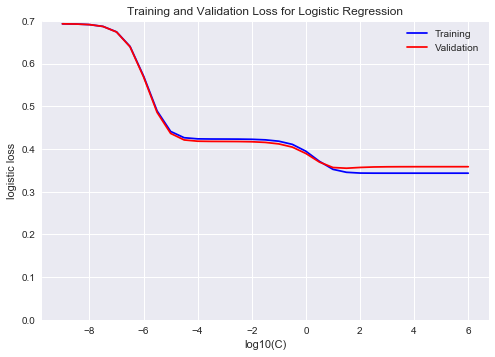

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [167]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

plt.plot([math.log10(c) for c in C_grid], tr_loss_list, color='blue', label="Training")
plt.plot([math.log10(c) for c in C_grid], va_loss_list, color='red', label="Validation")
plt.legend()
plt.title('Training and Validation Loss for Logistic Regression')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.show()

print("Best C-value for LR with 2-feature data: %.3f" % best_model_C) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_model_loss)

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

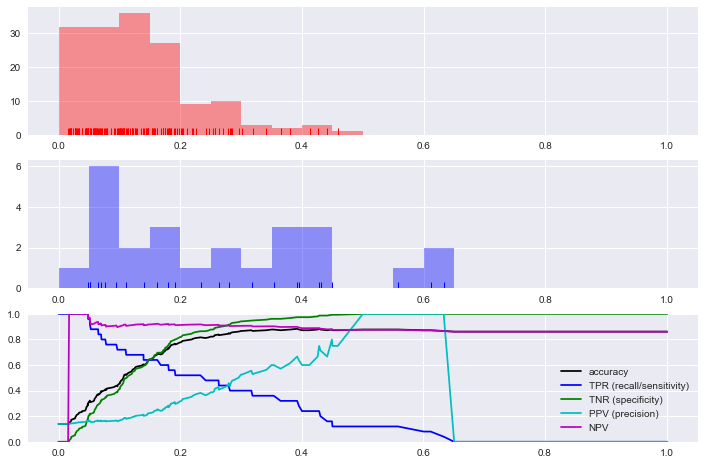

In [168]:
best_clf = sklearn.linear_model.LogisticRegression(C=best_model_C, solver="liblinear")
best_clf.fit(x_tr_M2, y_tr_M)
best_probabilities = best_clf.predict_proba(x_va_N2)
make_plot_perf_vs_threshold(y_va_N, best_probabilities[:,-1])

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [169]:
tr_loss_list3 = list()
va_loss_list3 = list()

# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
for C in C_grid:
    Tclf = sklearn.linear_model.LogisticRegression(C=C, solver="liblinear")
    Tclf.fit(x_tr_M3, y_tr_M)
    Tpredictions = Tclf.predict_proba(x_tr_M3)
    Vpredictions = Tclf.predict_proba(x_va_N3)
    tr_loss_list3.append(sklearn.metrics.log_loss(y_tr_M, Tpredictions))
    va_loss_list3.append(sklearn.metrics.log_loss(y_va_N, Vpredictions))
    
best_model_loss3 = min(va_loss_list3)
best_model_C3    = C_grid[va_loss_list3.index(best_model_loss3)]

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

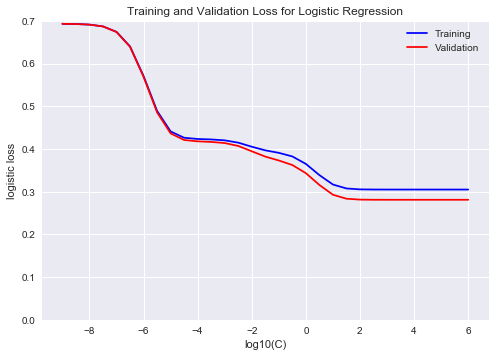

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


In [170]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.0, 0.7]);

plt.plot([math.log10(c) for c in C_grid], tr_loss_list3, color='blue', label="Training")
plt.plot([math.log10(c) for c in C_grid], va_loss_list3, color='red', label="Validation")
plt.legend()
plt.title('Training and Validation Loss for Logistic Regression')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.show()

print("Best C-value for LR with 3-feature data: %.3f" % best_model_C3) # TODO
print("Validation set log-loss at best C-value: %.4f" % best_model_loss3)

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

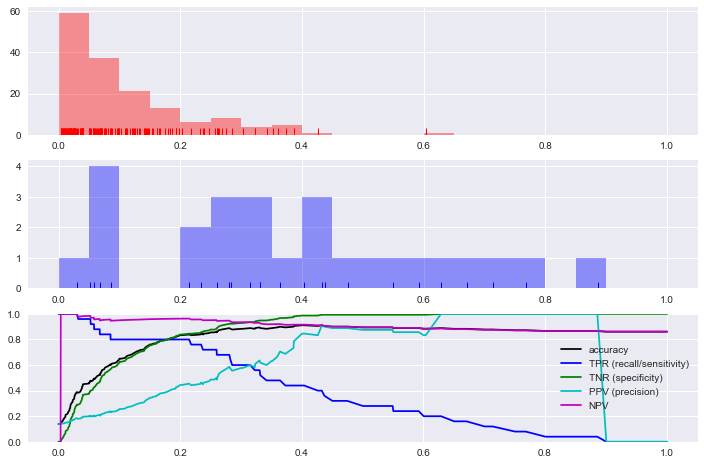

In [171]:
best_clf3 = sklearn.linear_model.LogisticRegression(C=best_model_C3, solver="liblinear")
best_clf3.fit(x_tr_M3, y_tr_M)
best_probabilities3 = best_clf3.predict_proba(x_va_N3)
make_plot_perf_vs_threshold(y_va_N, best_probabilities3[:,-1])

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

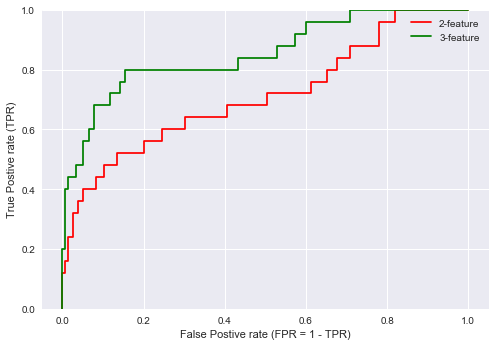

In [173]:
fpr2, tpr2, _ = sklearn.metrics.roc_curve(y_va_N, best_probabilities[:,-1])
fpr3, tpr3, _ = sklearn.metrics.roc_curve(y_va_N, best_probabilities3[:,-1])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.plot(fpr2, tpr2, color='red', label="2-feature")
plt.plot(fpr3, tpr3, color='green', label="3-feature")
plt.legend()
plt.show()

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

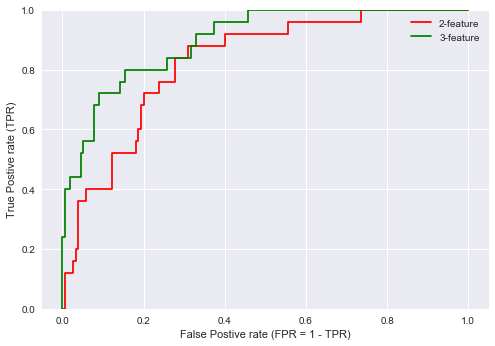

In [174]:
best_probabilities_test  = best_clf.predict_proba(x_te_N2)
best_probabilities3_test = best_clf3.predict_proba(x_te_N3)

fpr2t, tpr2t, _ = sklearn.metrics.roc_curve(y_te_N, best_probabilities_test[:,-1])
fpr3t, tpr3t, _ = sklearn.metrics.roc_curve(y_te_N, best_probabilities3_test[:,-1])

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.plot(fpr2t, tpr2t, color='red', label="2-feature")
plt.plot(fpr3t, tpr3t, color='green', label="3-feature")
plt.legend()
plt.show()

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: In both validation and testing (1.5a and 1.5b), the 3-feature classifier (green) dominates the 2-feature classifier (red). There is a small region in 1.5b where 2-feature is winning, but overall this is not significant, since the 3-feature wins everywhere else. This tells us that using the 3-feature dataset results in a higher True Positive Rate and a lower False Positive Rate overall than using the 2-feature dataset. Therefore, we interpret these graphs to mean that we should use the 3-feature dataset in our experiments.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [175]:
best_thr = 0.5


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [176]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best_probabilities3[:,-1])
tpr_ppv = zip(perf_grid["tpr"], perf_grid["ppv"])
best_metrics = max(tpr_ppv, key= lambda pair: (pair[0] + pair[1]) if pair[1] >= 0.98 else 0)
for i, pair in enumerate(zip(perf_grid["tpr"], perf_grid["ppv"])):
    if pair == best_metrics:
        index = i
        break
best_thr = thresh_grid[index]


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr )
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [177]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best_probabilities3[:,-1])
tpr_ppv = zip(perf_grid["tpr"], perf_grid["ppv"])
best_metrics = max(tpr_ppv, key= lambda pair: (pair[0] + pair[1]) if pair[0] >= 0.98 else 0)
for i, pair in enumerate(zip(perf_grid["tpr"], perf_grid["ppv"])):
    if pair == best_metrics:
        index = i
        break
best_thr = thresh_grid[index]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr )
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, best_probabilities3_test[:,-1], best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: In our case, life threatening mistakes are False Negatives - we want to avoid those at all costs. False Negatives occur when we *predict* negative (0) but our output is really positive (1). Comparing the three confusion matrices, we see that the third one (part c) is the best, since it has the lowest number of False Negatives. We also see that although c seems like the worst based on accuracy (0.456 is the lowest of all), the TPR is 1.000 - the highest of all three classifiers - meaning the classifier correctly identifies all sick people. The fact that the True Negative Rate is so low at 0.368 means that a significant amount of patients would be labeled as sick when they are in fact healthy. Although this may be emotionally jarring, it is less consequential than mislabeling a truly sick person as healthy. Therefore, it may prompt a few additional biopsies, but it will not make life threatening mistakes (for this dataset, few to none for other). Thus, the third classifier is the best overall.

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: 57 patients in our testing dataset would have been spared unnecessary biopsises, since we would have recognized that they are healthy. Overall, the hospital would have avoided performing ~37% of the biopsies it would normally perform, since that is the True Negative Rate for this classifier.

## Part Two: Decision Trees

You should start by computing the two heuristic values for the toy data described in the assignment handout. You should then load the two versions of the abalone data, compute the two heuristic values on features (for the simplified data), and then build decision trees for each set of data.

### 2.1 Compute both heuristics for toy data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [178]:
print("{}: {}/{}, {}: {}/{} ".format("A", 6, 8, "B", 6, 8,))

A: 6/8, B: 6/8 


#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [180]:
def entropy(*args):
    e = 0
    for arg in args:
        e -= arg*math.log2(arg) if arg > 0 else 0
    return e

print("{2:}: {3:.3f}, {0:}: {1:.3f} ".format("A", 1 - (0.25*entropy(0, 1) + 0.75*entropy(2/6, 4/6)), 
                                             "B", 1 - (0.5*entropy(0.75, 0.25) + 0.5*entropy(0.25, 0.75))))

B: 0.189, A: 0.311 


#### (c) Discussion of results.

If we built a tree with using the first heuristic, we would conclude that the choice to use A or B as the root is arbitrary, since they both have a counting-based heuristic value of 6/8. 
On the other hand, if we built a tree using the second heuristic, we would see that B is a much better choice for our root feature, since we gain more information (mathematically speaking) from splitting our dataset on it than using A as the root. 

This underscores the importance of choosing a meaningful heuristic when building these trees, and shows how choosing a poor heuristic can be misleading. Using multiple heuristics and comparing may be optimal.

### 2.2 Compute both heuristics for simplified abalone data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [181]:
mini_x_tr = np.loadtxt('./data_abalone/small_binary_x_train.csv', delimiter=',', skiprows=1)
mini_y_tr = np.loadtxt('./data_abalone/3class_y_train.csv', delimiter=',', skiprows=1)

def get_majority(pile):
    outputs = []
    for x, y in pile:
        outputs.append(y)
    return statistics.mode(outputs)
        
def number_correct(pile, majority):
    n = 0
    for x, y in pile:
        if y == majority:
            n += 1
    return n

def C_pretty_print(feature_labels, counts, total):
    counts = sorted(counts, key= lambda x: x[0], reverse=True)
    for i, count in enumerate(counts):
        print("{}: {}/{}".format(feature_labels[str(counts[i][1])], counts[i][0], total), end = "")
        print(", " if i < 3 else "", end = "")
    

features = [[] for f in range(2 * len(mini_x_tr[0]))]
for i in range(0, len(features), 2):
    for xy in zip(mini_x_tr, mini_y_tr):
        currF = int(i/2)
        features[i + int(xy[0][currF])].append(xy)

total = 3176
counting_heuristic = [number_correct(feature, get_majority(feature)) for feature in features]
counts = [(counting_heuristic[i]+counting_heuristic[i+1], int(i/2)) for i in range(0, len(counting_heuristic), 2)]
feature_labels = { "0": "is_male", 
                   "1": "length_mm",
                   "2": "diam_mm",
                   "3": "height_mm"
                 }
C_pretty_print(feature_labels, counts, total)

height_mm: 2316/3176, diam_mm: 2266/3176, length_mm: 2230/3176, is_male: 1864/3176

#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [183]:
def split_classes(mini, num_classes):
    splits = [0 for i in range(num_classes)]
    for y in mini:
        splits[int(y[1])] += 1
    return splits

def divide_classes(mini, num_classes):
    splits = [0 for i in range(num_classes)]
    for y in mini:
        splits[int(y)] += 1
    return splits

def get_remainders(remainders, features, total):
    for i, pile in enumerate([feature for feature in features]):
        class1, class2, class3 = split_classes(pile, 3)
        remainders[i] =  (len(pile)/total) * entropy(class1/len(pile), class2/len(pile), class3/len(pile))
    return remainders

def I_pretty_print(feature_labels, counts, total):
    counts = sorted(counts, key= lambda x: x[0], reverse=True)
    for i, count in enumerate(counts):
        print("{}: {:.3f}".format(feature_labels[str(counts[i][1])], counts[i][0]), end = "")
        print(", " if i < 3 else "", end = "")

class1_size, class2_size, class3_size = divide_classes(mini_y_tr, 3)
H = entropy(class1_size/total, class2_size/total, class3_size/total)
remainders = [0 for f in range(2*len(mini_x_tr[0]))]
remainders = get_remainders(remainders, features, total)
feature_remainders = [(remainders[i] + remainders[i+1], int(i/2)) for i in range(0, len(remainders), 2)]
gainz = [(H - remainder[0], remainder[1]) for remainder in feature_remainders]
I_pretty_print(feature_labels, gainz, total)

height_mm: 0.173, diam_mm: 0.150, length_mm: 0.135, is_male: 0.025

### 2.3 Generate decision trees for full- and restricted-feature data

#### (a) Print accuracy values and generate tree images.

In [186]:
mini_groot = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
big_groot  = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
mini_x_te = np.loadtxt('./data_abalone/small_binary_x_test.csv', delimiter=',', skiprows=1)
mini_y_te = np.loadtxt('./data_abalone/3class_y_test.csv', delimiter=',', skiprows=1)
big_x_tr  = np.loadtxt('./data_abalone/x_train.csv', delimiter=',', skiprows=1)
big_y_tr  = np.loadtxt('./data_abalone/y_train.csv', delimiter=',', skiprows=1)
big_x_te  = np.loadtxt('./data_abalone/x_test.csv', delimiter=',', skiprows=1)
big_y_te  = np.loadtxt('./data_abalone/y_test.csv', delimiter=',', skiprows=1)

mini_groot.fit(mini_x_tr, mini_y_tr)
mini_train = mini_groot.score(mini_x_tr, mini_y_tr)
mini_test  = mini_groot.score(mini_x_te, mini_y_te)
big_groot.fit(big_x_tr, big_y_tr)
big_train  = big_groot.score(big_x_tr, big_y_tr)
big_test   = big_groot.score(big_x_te, big_y_te)

print("Binary Training Score: {:.3f}".format(mini_train))
print("Binary Testing Score:  {:.3f}".format(mini_test))
print("Real Training Score:   {:.3f}".format(big_train))
print("Real Test Score:       {:.3f}".format(big_test))


dot_data = sklearn.tree.export_graphviz(mini_groot, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("Binary Data Tree")

dot_data2 = sklearn.tree.export_graphviz(big_groot, out_file=None) 
graph2 = graphviz.Source(dot_data2) 
graph2.render("Full Data Tree")

Binary Training Score: 0.733
Binary Testing Score:  0.722
Real Training Score:   1.000
Real Test Score:       0.176


'Full Data Tree.pdf'

#### (b) Discuss the results seen for the two trees

The Binary Data Tree is *much* smaller than the Full Data Tree. The fact that the Full Data Tree (non-binary data) is so large leads us to believe it is massively overfit to our training data. If we zoom in on some of the branches, it has a lot of nodes where the number of data points from most classes is zero (in most cases, all but one class has a nonzero value), meaning it basically created a path for every outcome seen in the training dataset.

We see this further reflected in the fact that most nodes at depth >= 3 have entropy zero in the full tree- meaning they have been perfectly divided across each feature, and our real training score is perfect (1.000). Notice however that our Real Test score is 0.176 - meaning the full tree fails ~82% of the time on new data. Once again, this leads us to believe there is a lot of overfitting going on.

For the binary data, performance remains relatively unchanged (and high) across both the Training and Testing, with over 70% accuracy in both cases.

Overall, this shows that the Binary data, although much smaller/simpler than the real dataset, is much more accurate. This in turn would suggest that the 4 characteristics that were discarded in the binary dataset - namely, whole_weight_g, shucked_weight_g, viscera_weight_g, and shell_weight_g - may not actually be as important, since we can still get over 70% accuracy by ignoring them completely.

Looking at the leaves of both trees, we see that the Binary Data Tree's leaves have much higher entropy than those in the Full Data Tree, although still less than the 1.062 we started with. Looking at the Binary Tree, we see that in most cases, the tree completely eliminates one possible output value and is having trouble deciding between the final two, although there is a slight bias towards the correct answer in many cases, giving us our relatively high accuracy on binary data.